This Python notebook demonstrates how to generate custom A, B SSM matrices over arbitrary bases or frames.

In [1]:
# start by importing necessary libraries
import safari
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 64   # N is the dimension of the SSM
L = 2**14    # L is the length of the frame. For closed-form solutions (HiPPO), this parameter is ignored; L is effecively infinity.
            # For numerically computed SSMs (SaFARi), larger L gives smaller discretization of the frame, but increases computation time.

The syntax to generate the SSM is: \<SSM object\> = safari.SSM(\<keyword, value pairs\>).
The SSM object contains the transition matrix A, weight vector B, and the frame object. 

The minimum information you must pass to the safari.SSM function is a *frame*.  
A frame can be provided either as an N x L array, or the name of a built-in frame option.

For quick reference of syntax, available options, and default values, use safari.ssm_options:

In [3]:
safari.ssm_options() # lists available SSM options

+------------------------+-----------+------------------------+-----------------+
| Parameter              | keyword   | options                | default value   |
+========================+===========+========================+=================+
| Measure                | meas      | scaled, translated     | scaled          |
+------------------------+-----------+------------------------+-----------------+
| Frame type             | fname     | see safari.framelist() | custom          |
+------------------------+-----------+------------------------+-----------------+
| Frame                  | F         | N x L numpy array      | None            |
+------------------------+-----------+------------------------+-----------------+
| Derivative of Frame    | dF        | N x L numpy array      | None            |
+------------------------+-----------+------------------------+-----------------+
| Dual of Frame          | D         | N x L numpy array      | None            |
+---------------

SaFARi generates the SSM in one of the following ways, depending on the options you pass to it.  

1) If your chosen measure and frame type correspond to a known closed-form solution from HiPPO, then the HiPPO solution is returned. [REFERENCE]
2) If your chosen frame type (fname) is a built-in option, then that frame is created by the Frame_Builder utility with size N x L, and the SaFARi numerical solution is returned.
3) If you provide a custom frame (F), N and L are inferred from the size of F, and the SaFARi numerical solution is returned. You can provide dF and D as well, but if you do not, then dF is computed via finite-difference method, and D is computed via pseudoinverse.

To see a list of available frames and information, use the following command:

In [4]:
safari.framelist()

+-----------------------+-----------------+--------------+----------------------+----------------------------------------------+
| Frame Name            | Keyword Value   | Addl. Opts   | Default Vals         | Notes                                        |
+=======================+=================+==============+======================+==============================================+
| Legendre Polynomials  | legendre        | N/A          | N/A                  | Not stably diagonalizable for N > 20         |
+-----------------------+-----------------+--------------+----------------------+----------------------------------------------+
| Fourier Basis         | fourier         | N/A          | N/A                  | Rank is N+1 due to DC term                   |
+-----------------------+-----------------+--------------+----------------------+----------------------------------------------+
| Chebyshev Polynomials | chebyshev       | N/A          | N/A                  | N/A            

Let's generate a few examples:

In [9]:
# closed form solution exists:
hippo_legs = safari.SSM(N=N, L=L, fname='legendre', meas='scaled')
hippo_fourier = safari.SSM(N=N, L=L, fname='fourier', meas='scaled')
# gabor filters:
safari_gabor = safari.SSM(N=N, L=L, fname='gabor', meas='scaled', m=4, redundancy=0.1)

Using HiPPO closed-form solution for A, B
Generating HiPPO-LegS
The scaled legendre SSM is non-diagonalizable with effective rank: 64 

The scaled fourier SSM is diagonalizable with effective rank: 65 

The scaled gabor SSM is diagonalizable with effective rank: 63 



We can visualize the A matrices created by each:

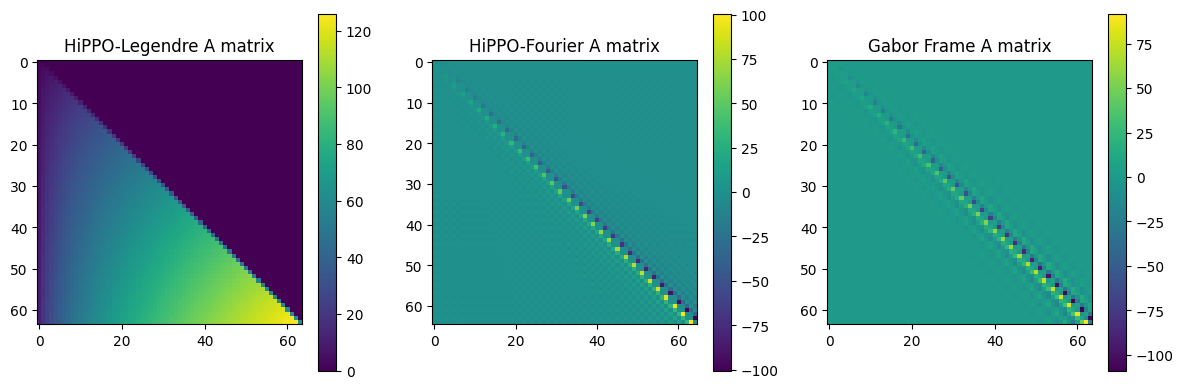

In [6]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(hippo_legs.A.real, cmap='viridis')
plt.title('HiPPO-Legendre A matrix')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(hippo_fourier.A.real, cmap='viridis')
plt.title('HiPPO-Fourier A matrix')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(safari_gabor.A.real, cmap='viridis')
plt.title('Gabor Frame A matrix')
plt.colorbar()
plt.tight_layout()
plt.show()

We can now use our SSMs to memorize a signal.

A is not diagonal.
A is diagonal.
A is diagonal.


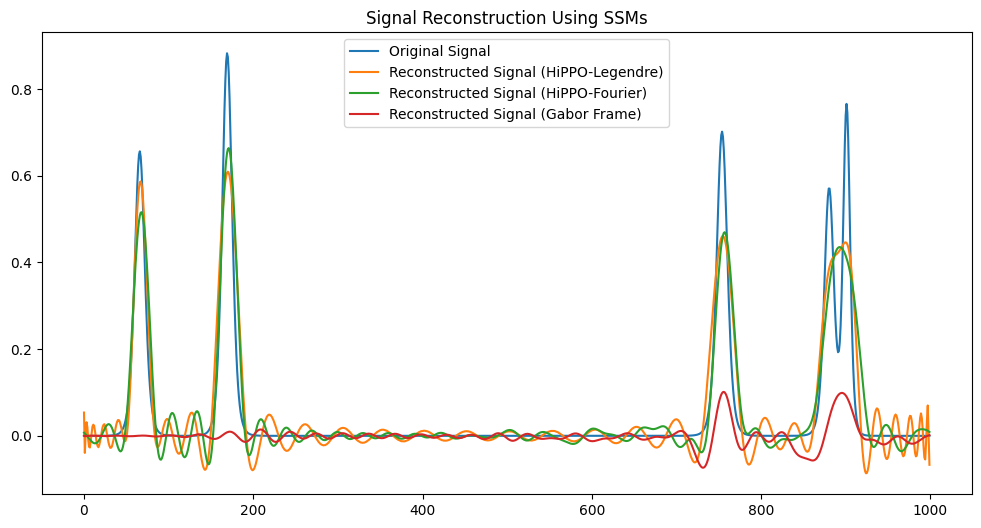

In [7]:
l = 1000
#signal = safari.synthetic_signal.generate_rand_data(l,smooth=True)
n = 5 
#spikes
bump_locs = np.random.uniform(0, 1, size=n)
bump_heights = np.random.uniform(0.1, 1.0, size=n)
bump_widths = np.random.uniform(0.01, 0.02, size=n)
signal = safari.Test_Function_Generator.synthetic_signal.bumps(l, bump_heights, bump_locs, bump_widths)
#signal = safari.Test_Function_Generator.synthetic_signal.generate_rand_data(l, smooth=False)

c_hippo_legs = safari.compute_ssm_state(hippo_legs, signal)
xhat_hippo_legs = safari.reconstruct(c_hippo_legs, l, hippo_legs.Fobj.D)

c_hippo_fous = safari.compute_ssm_state(hippo_fourier, signal)
xhat_hippo_fous = safari.reconstruct(c_hippo_fous, l, hippo_fourier.Fobj.D)

c_gabor = safari.compute_ssm_state(safari_gabor, signal)
xhat_gabor = safari.reconstruct(c_gabor, l, safari_gabor.Fobj.D)

plt.figure(figsize=(12, 6)) 
plt.plot(signal, label='Original Signal')
plt.plot(xhat_hippo_legs, label='Reconstructed Signal (HiPPO-Legendre)')
plt.plot(xhat_hippo_fous, label='Reconstructed Signal (HiPPO-Fourier)')
plt.plot(xhat_gabor, label='Reconstructed Signal (Gabor Frame)')
plt.legend()
plt.title('Signal Reconstruction Using SSMs')
plt.show()

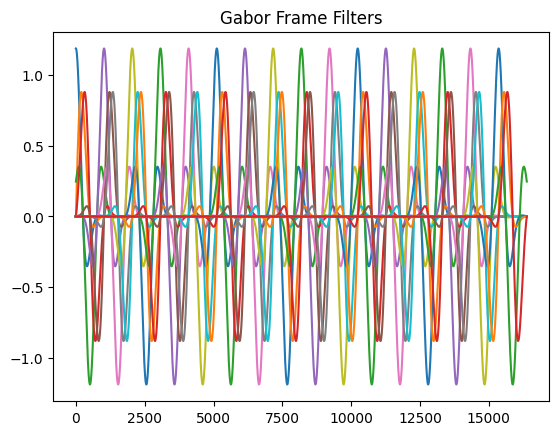

In [8]:
plt.plot(safari_gabor.Fobj.F.T)
plt.title('Gabor Frame Filters')
plt.show()